In [2]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [3]:
dane_kopia = pd.read_excel("default of credit card clients.xls")
print(dane_kopia.shape)
dane_kopia.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,female,university,married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,yes
1,2,120000,female,university,single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,yes
2,3,90000,female,university,single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,no
3,4,50000,female,university,married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,no
4,5,50000,male,university,married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,no


In [4]:
# usuniecie zmiennej porzadkowej ID
dane_kopia = dane_kopia.drop(columns=['ID'])

In [5]:
dane_kopia.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [6]:
#zmiana nazw kolumn
dane_kopia.columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default']

In [7]:
objasniana = "default"

In [8]:
objasniajace_numeryczne = ['LIMIT_BAL', 'AGE',
                           'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                           'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [9]:
objasniajace_kategoryczne = ['SEX', 'EDUCATION', 'MARRIAGE', 
                             'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [10]:
from sklearn import preprocessing
dane = dane_kopia.copy()
mapy = {}
for zmienna in objasniajace_kategoryczne:
    # Obiekt do kodowania, który będzie przechowywał naszą mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy daną (tworzymy mapę) i nakadamy ją na zmienną, na której robiliśmy dopasowanie
    dane[zmienna] = le.fit_transform(dane_kopia[zmienna])

    # Zapiszmy nasza mapę, aby móc odzyskać oryginalne dane bez problemu
    mapy[zmienna] = le

In [11]:
# robimy listę zmiennych objaśniających

lista_zmiennych = dane.columns.tolist()
lista_zmiennych.remove(objasniana)
print(lista_zmiennych)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [12]:
dane[objasniana] = (dane[objasniana]=="yes").astype(int)

# Podstawowy XGBoost:

Definiujemy funkcję do liczenia podstawowej wersji modelu - póki co bez składanej walidacji krzyżowej, ale ze zwykłą walidacją krzyzową. Jako domyślne ustwiamy parametry: eta (parametr uczenia się): 0.03, maksymalna głebokość: 7, maksymalna liczba drzew: 1000, wielkość próby losowanej do każdego drzewa: 70% obserwacji i 70% zmiennych. Dodatkowo ustwiamy wartość early stoppingu na 50, co oznacza, że jeśli przez kolejnych 50 powtórzeń model nie osiągnie poprawy wyniku, algorytm będzie zatrzymywany. 

In [13]:
def podstawowy_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=1997, booster = "gbtree", tree_method="hist", grow_policy="depthwise",
           verbosity=1, silent=False): # konfiguracja

   
    czas_poczatkowy = time.time()
    lista_parametrow= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy', 'verbosity', 'silent']
    
    # Stworzenie słownika do przekazania do XGB
    parametry = dict()
    for parametr in lista_parametrow:
        parametry[parametr]=eval(parametr)
    if(debug):
        for parametr in lista_parametrow:
            print(parametr, eval(parametr), end=", ")
        print('\nDługość treningowa:', len(train.index))
        print('Długość walidacyjna:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (parametry["objective"]=="multi:softmax" or parametry["objective"]=="multi:softprob"):
        parametry["num_class"]=train[target].nunique()
    parametry["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    parametry["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    d_treningowe = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    d_walidacyjne = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    ewaluacje = [(d_treningowe, 'train'), (d_walidacyjne, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    historia_treningowe_pd = dict()

    # Uruchomienie algorytmu trenującego
    trenowanie = xgb.train(parametry, d_treningowe, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=ewaluacje, evals_result=historia_treningowe_pd, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    oszacowania = trenowanie.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    historia_treningowe = dict()
    for key in historia_treningowe_pd.keys():
        for metric in historia_treningowe_pd[key].keys():
            historia_treningowe[key+metric.upper()]=historia_treningowe_pd[key][metric]
    historia_treningowe_pd = pd.DataFrame(historia_treningowe)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    predykcje_treningowe = trenowanie.predict(d_treningowe, ntree_limit=trenowanie.best_iteration)
    predykcje_testowe = trenowanie.predict(d_walidacyjne, ntree_limit=trenowanie.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    waznosc = trenowanie.get_fscore()
    waznosc = sorted(waznosc.items(), key=itemgetter(1), reverse=True)

    waznosc_wykres=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - czas_poczatkowy)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        waznosc_wykres, ax = plt.subplots()
        xgb.plot_importance(trenowanie, ax=ax)
    return oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc

Dzielimy zbiór na podzbiór treningowy (20% obserwacji - 6000) i walidacyjny (80% obserwacji - 24000). Dzięki parametrowi stratify podział zachowa porównywalne proporcje obserwacji, dla których zmienna objaśniana przyjmuje odpowiednio wartości 0 i 1 w próbie treningowej i walidacyjnej. 

In [14]:
rozmiar_testowa = 0.2
X_train, X_valid = train_test_split(dane, test_size=rozmiar_testowa, random_state=1997, stratify=dane[objasniana].values)

In [15]:
X_train.shape

(24000, 24)

In [16]:
X_valid.shape

(6000, 24)

Poniżej uruchamiamy XGBoost pierwszy raz. Większość parametrów zostawiamy na domyślym poziomie zadeklarownym przy tworzeniu funkcji. Jedynym parametrem, dla którego spradzamy inne ustawienie jest early_stopping_rounds odpowiedzialny za wysokość marginesu dla early_stopping. Zwiększamy go do 50 i zobaczymy, czy model się przetrenuje.

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 1997, booster gbtree, tree_method hist, grow_policy depthwise, verbosity 1, silent False, 
Długość treningowa: 24000
Długość walidacyjna: 6000
[18:48:34] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.77675	valid-auc:0.74534
[1]	train-auc:0.78835	valid-auc:0.75314
[2]	train-auc:0.79590	valid-auc:0.75861
[3]	train-auc:0.79852	valid-auc:0.76001
[4]	train-auc:0.79902	valid-auc:0.75882

[179]	train-auc:0.87504	valid-auc:0.77834
[180]	train-auc:0.87543	valid-auc:0.77831
[181]	train-auc:0.87585	valid-auc:0.77822
[182]	train-auc:0.87632	valid-auc:0.77811
[183]	train-auc:0.87672	valid-auc:0.77823
[184]	train-auc:0.87720	valid-auc:0.77816
[185]	train-auc:0.87768	valid-auc:0.77814
[186]	train-auc:0.87830	valid-auc:0.77812
[187]	train-auc:0.87853	valid-auc:0.77814
[188]	train-auc:0.87879	valid-auc:0.77800
[189]	train-auc:0.87933	valid-auc:0.77798
[190]	train-auc:0.87971	valid-auc:0.77812
[191]	train-auc:0.88016	valid-auc:0.77796
[192]	train-auc:0.88045	valid-auc:0.77793
[193]	train-auc:0.88066	valid-auc:0.77793
[194]	train-auc:0.88095	valid-auc:0.77797
[195]	train-auc:0.88139	valid-auc:0.77783
[196]	train-auc:0.88159	valid-auc:0.77783
[197]	train-auc:0.88206	valid-auc:0.77774
[198]	train-auc:0.88219	valid-auc:0.77775
[199]	train-auc:0.88262	valid-auc:0.77784
[200]	train-auc:0.88296	valid-auc:0.77788
[201]	train-auc:0.88312	valid-auc:0.77784
[202]	train-auc:0.88362	valid-auc:

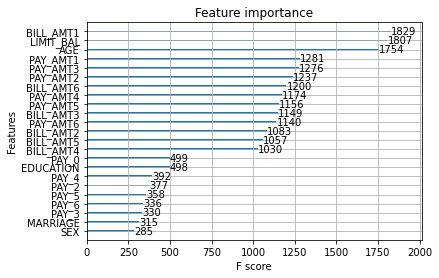

In [17]:
oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana, early_stopping_rounds=50)

Model wykonał 227 powtórzeń, co oznacza, że najlepszą wartość powinniśmy byl uzyskać w 177 rundzie. Jeśli posortujemy wyniki malejąco, zoabczymy, że faktycznie najlepszyw ynik na próbie walidacyjnej uzysaliśmy przy tym powtórzeniu. Jak widać poniżej, algorytm przetrenowuje się w momencie, w którym AUC na zbiorze wlaidacyjnym wynosi 77,84%. Dzięki zastosowaniu early stopping, zatrzymujmy algorytm w momencie, w którym wynik przestaje się polepszać.

Dla zastosowanych parametrów najbardziej istotne w modelu okazały się zmienne BILL_AMT1, LIMIT_BALL i AGE. 

In [18]:
historia_treningowe_pd.sort_values(by = 'validAUC', ascending = False)

,trainAUC,validAUC
177,0.874114,0.778405
178,0.874654,0.778389
176,0.873702,0.778355
179,0.875045,0.778338
180,0.875427,0.778311
...,...,...
3,0.798522,0.760006
4,0.799022,0.758820
2,0.795895,0.758607
1,0.788352,0.753141


Na wykresie poniżej widzimy, że o ile na zbiorze treningowym cały czas uzyskujemy poprawę wyniku, o tyle na zbiorze walidacyjnym wyniki polepsza nie tylko znacznie wolniej, ale także przestaje w ogóle wzratstać po 177 (co wiemy z wyników powyżej) powrtórzeniu.

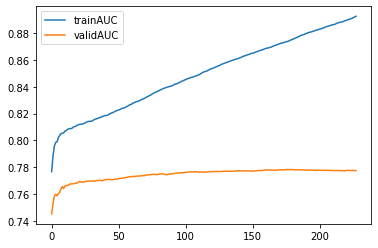

In [19]:
historia_treningowe_pd.plot()
plt.show()

# Dobór hiperparametrów przy uzyciu walidacji krzyżowej:

## Głębokość drzewa: max_depth

Zaczynamy od przeszukania zakresu zakresu różnych głębokości drzewa - co 2, pomiędzy minimalną 2 i maksymalną wartoscią 14. Reszta parametrów zostaje na domyślnym poziomie. Dalej stosujemy early stopping dla 50 rund.

2 0.778295
4 0.77912
6 0.779453
8 0.778726
10 0.774052
12 0.773256
14 0.774264


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

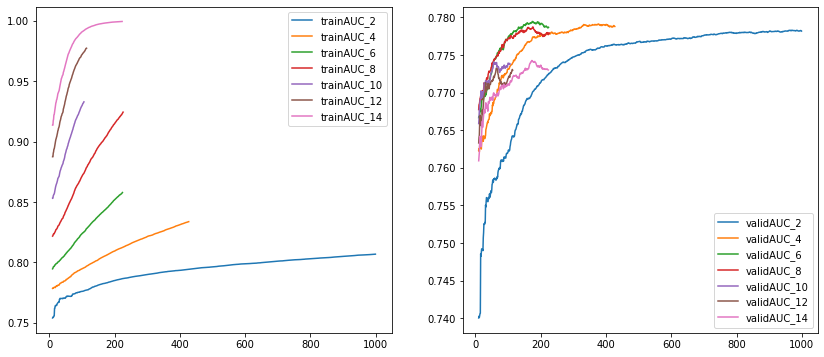

In [26]:
# Obiekt na wyniki
wykresy_wynikow = dict()
zakres = range(2,15,2)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana,
                                                          max_depth=x, early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Z powyższych wykresów odczytujemy, że przy głebokościach 8, 10, 12 i 14 następuje przeuczenie (overfitting) modelu - modele na zbiorze treningowym uczą się bardzo syzbko, ale nie przekłada się to już na coraz wyższe wyniki na zbiorze walidacyjnym. Z kolei dla modeli z maksymalną glębokością na niższym poziomie uczenie się jest wolniejszym procesem, ale nie następuje przeuczenie i wraz ze zwiększaniem dla głebokości 2, 4 i 8 obserwujemy wzrost wyniku na próbie walidacyjnej. Ponieważ dla głebokości 6 otrzymujemy najelpesze wyniki na próbie testowej, decydujemy się na te głebokość drzewa.

3 0.779086
4 0.77912
5 0.779023
6 0.779453
7 0.778405
8 0.778726
9 0.775517


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

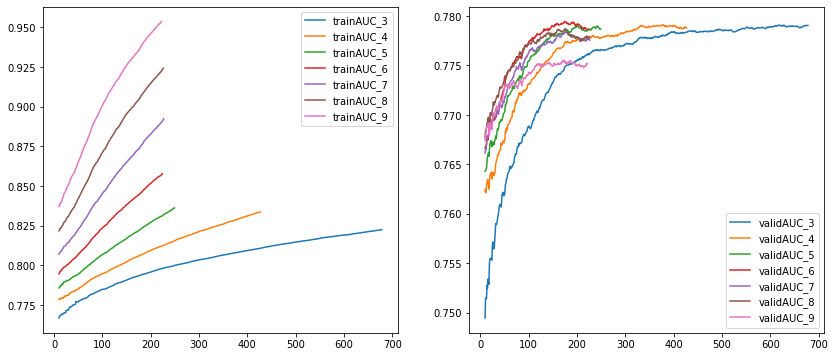

In [27]:
# Obiekt na wyniki
wykresy_wynikow = dict()
zakres = range(3,10,1)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana,
                                                          max_depth=x, early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Potwierdza się, że najlepszy wynik osiągamy dla głebokości 6, więc na razie będziemy szukać innych hiperparametrów dla tej głebokości drzewa.

## Udział wierszy: subsample

Szukamy najlepszej wartości dla udział wierszy w modelu - sprawdzamy, jakie wyniki osiągniemy dla losowania różnej wielkości podpróbek w modelu. Przeszukujemy wartości od 30% do 90%.

0.3 0.778219
0.4 0.777074
0.5 0.779485
0.6 0.777866
0.7 0.779453
0.8 0.778503
0.9 0.780012


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

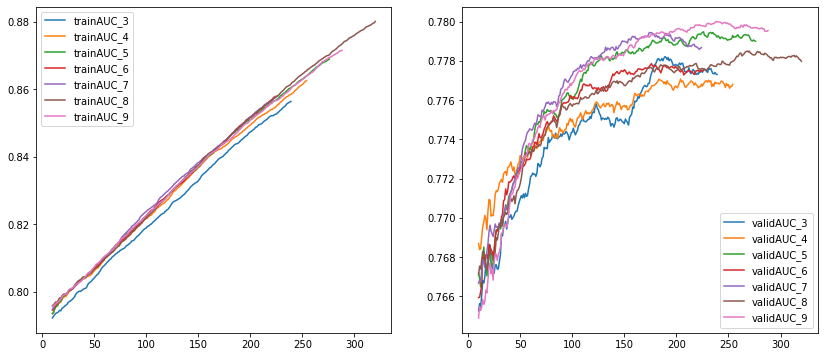

In [28]:
wykresy_wynikow = dict()
zakres = range(3,10)
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana,
                                                          max_depth=6,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x/10, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Różnice pomiędzy wynikami nie są duże, a dodatkowo wraz ze wzrostem wielkości losowanych podpróbek wynik naprzemie polepsza się i pogarsza. Najlepsze wyniki otrzymujemy dla udziału wierszy na poziomie 0.7 i 0.9. Dla wartości 0.8 model zdecydowanie się przetrenowuje i mimo najlepszych wyników na próbie treningwej, nie osiąga najlpeszych na próbie walidacyjnej. Z racji lepszego wyniku na próbie walidacyjnej, decydujemy się na wartość 0.9.

## Udział kolumn: colsample_bytree

Sprawdzamy, czy zmieniając udział zmiennych w losowanej próbie możemy polepszyć wynik modelu. Liczymy modele dla udziału kolumn na poziomie od 30% do 90%. Pozostałe parametry pozostają na wybranych wcześniej poziomach - udział wierszy 0.9 i głebokość 6.

0.3 0.769151
0.4 0.778948
0.5 0.779519
0.6 0.778837
0.7 0.780012
0.8 0.778369
0.9 0.77763


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

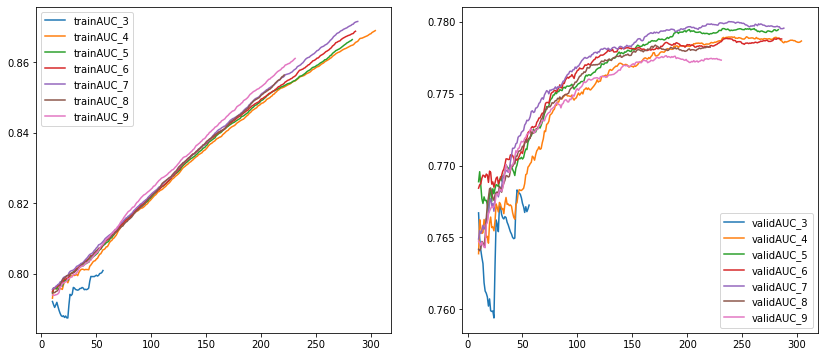

In [36]:
wykresy_wynikow = dict()
zakres = range(3,10)
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana,
                                                          max_depth=6, subsample=0.9, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x/10, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Potwierdziło się, że udział zmiennych w losowanej próbce na poziomie 70% daje najlepsze wyniki. Z jednej strony 90% daje lepszy wynik na próbie treningowej, ale model przetrenowuje się i na próbie walidacyjnej ten poziom nie daje najlepszych rezultatów. Z drugiej strony inne wartosći nie dają większego wyniku ani na próbie treningowej, ani walidacyjnej. Pozostajemy zatem z parametrem na poziomie 70%. 

Ponieważ dla udziału wierszy na poziomie 70% i 90% uzyskiskiwaliśmy zbliżone wyniki, dla pewności sprawdzmy, jakie wyniki otrzymamy dla różnych wielkości losowanej próbki zmiennych przy udziale wierwszy na poziomie 70%. 

0.3 0.779555
0.4 0.779054
0.5 0.779856
0.6 0.779459
0.7 0.779453
0.8 0.780377
0.9 0.778128


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

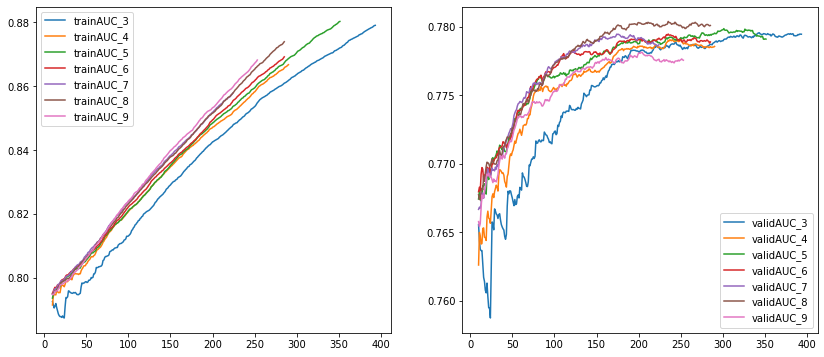

In [37]:
zakres = range(3,10)
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, impFig, imp = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana,
                                                          max_depth=6, subsample=0.7, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x/10, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Wyniki są jeszcze mniej zróżnicowane niż poprzednio. Tym razem najlepszym wyborem wydaje się być udział zmiennych na poziomie 80%. Można powiedzieć, że dla obu par wartości: subsample = 0.9 i colsample_bytree = 0.7 oraz subsample = 0.7 i colsample_bytree = 0.8 otrzymujemy najlepsze i prawie identyczne wyniki - odpowiednio 78.0012% i 78.0377%.

## Udział kolumn: colsample_bylevel

Sprawdzamy teraz, jak będzie zachowywał się model, jeśli zachowamy poprzednie parametry, ale zmienimy sposób losowania kolumn z drzewa na poziom. Parametr colsample_bytree zmieniamy teraz na równy 1, a modyfikować będziemy ustawienie parametru colsample_bylevel.

3 0.778416
4 0.77855
5 0.779095
6 0.777676
7 0.778037
8 0.7788
9 0.777767
10 0.777587


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

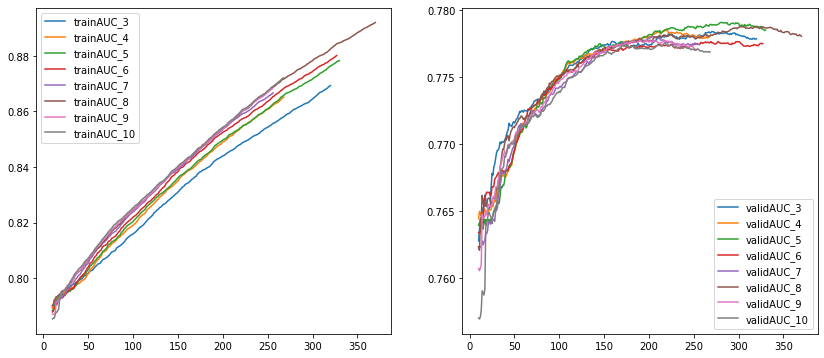

In [40]:
wykresy_wynikow = dict()
zakres = range(3,11)
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana,
                                                          max_depth=6, subsample=0.9, colsample_bytree=1, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Zarówno dla parametru subsample na poziomie 0.7 jak i 0.9, jeśli colsample_bytree ustawimy na poziomie 1, a zmieniać będzimy parametr colsample_bylevel, nasze wyniki nie tylko nie poprawiają się, ale niestaty pogarszają się. Zostaniemy zatem przy parametrze colsample_bytree.

## Regularyzacja: lambda^2

0 0.778203
1 0.780012
4 0.779637
9 0.779321
16 0.779042
25 0.779173
36 0.778626
49 0.778148


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

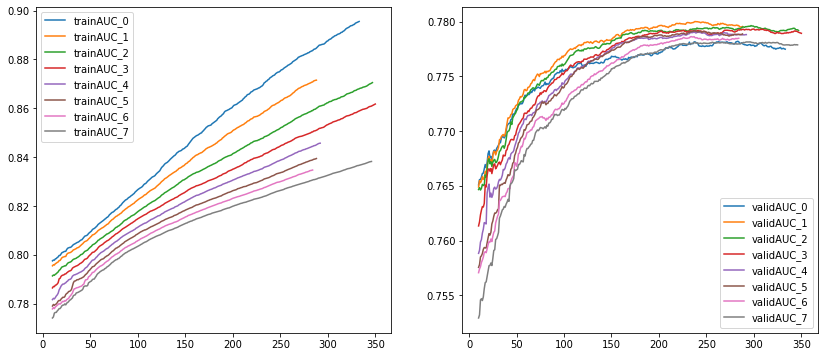

In [41]:
wykresy_wynikow = dict()

zakres = range(0,8)
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana, lambdaX=x**2,
                                                          max_depth=6, subsample=0.9, colsample_bytree=0.7,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    
    print(x**2, oszacowania)
    wykresy_wynikow[x]=historia_treningowe_pd
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Jak widzimy, zmiana parametru lambda z 1 na inne wartości nie przyniosła poprawy wyniku w modelu. Dla  Zostajemy zatem przy wartości 1, ponieważ powoduje ona uzyskanie najlepszego wyniku na probie walidacyjnej. Dla lambdy = 0 otrymujemy lpesze wyniki na próbie treningowej, ale model przetrenowauje się i nie polepsza wyniku na próbie walidacyjnej.

## Regularyzacja: gamma

Skoro manipulacja parametrem lanbda nie przyniosła oczekiwanych efektów, sprawdzamy, czy wprowadzenie zmian w parametrze gamma, odpowiedzialnym za decyzje o kolejnych splitach, poprawi wynik obliczanego modelu. Pozostajemy przy lambda = 1.

0 0.780012
0.01 0.78001
0.1 0.778573
0.5 0.779283
1 0.778437
2 0.778812
5 0.778238


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

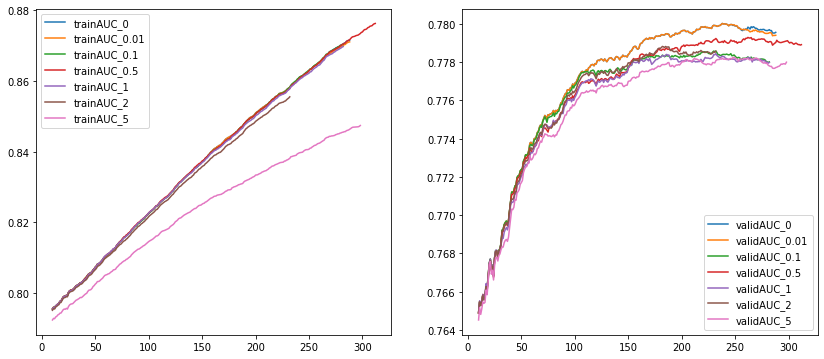

In [46]:
wykresy_wynikow = dict()
zakres = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in zakres:
    oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(X_train, X_valid, lista_zmiennych, objasniana, lambdaX=1,
                                                          max_depth=6, subsample=0.9, colsample_bytree=0.7,
                                                          gamma=x,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    wykresy_wynikow[x]=historia_treningowe_pd
    print(x, oszacowania)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in zakres:
    wykresy_wynikow[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    wykresy_wynikow[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Dla gammy na poziomie 0 i 0.01 otrzymujemy najlepsze wyniki, więc właściwie nie uzyskaliśmy poprawy. Dla wartości 0.1 i wyższych model przetrenowuje się i mimo zblizonych wyników na próbie treningowej, widzimy spadek na próbie walidacyjnej. 

# XGBoost - Walidacja krzyżowa

Tworzymy wrapper do walidacji krzyżowej, ponieważ podejrzewamy, że bez jej zastosowania i możem spodziewać się przetrenowania hiperparametrów. Jako wartości domyślne stosujemy wartości wybrane podczas testowania modelu bez walidacji krzyżowej.

In [49]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy prosty wrapper
def walidacja_krzyzowa_xgb(foldy = 5, randomState=1997, features=lista_zmiennych, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=foldy, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    wyniki_testowe = []
    wyniki_treningowe = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predykcje = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indeksy = []
    
    # Przygotujmy listę historii
    historie = []
    fold = 1
    for train, test in kf.split(dane.index.values):
        # Przygotowanie estymatora
        oszacowania, predykcje_treningowe, predykcje_testowe, historia_treningowe_pd, waznosc_wykres, waznosc = podstawowy_xgb(dane.iloc[train], dane.iloc[test],
                                                                         lista_zmiennych, objasniana, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predykcje.append(predykcje_testowe.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indeksy.append(dane.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        oszacowania_treningowe = roc_auc_score(dane[objasniana].iloc[train], predykcje_treningowe)
        oszacowania_testowe = roc_auc_score(dane[objasniana].iloc[test], predykcje_testowe)
        
        wyniki_treningowe.append(oszacowania_treningowe)
        wyniki_testowe.append(oszacowania_testowe)
        
        historie.append(historia_treningowe_pd.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", oszacowania_treningowe,
                  "Valid AUC:", oszacowania_testowe)
        
    return wyniki_treningowe, wyniki_testowe, predykcje, indeksy, pd.concat(historie, axis=1)

Pierwszy trening wykonujemy na wczeniej ustalonych parametrach.

In [50]:
wyniki_treningowe, wyniki_testowe, predykcje, indekst, historie = walidacja_krzyzowa_xgb(
    max_depth=6, lambdaX=1, subsample=0.9, colsample_bytree=0.7, gamma=0, debug=False, verbosity=0)
np.mean(wyniki_treningowe), np.mean(wyniki_testowe)

(0.8421268934985069, 0.7854550554295983)

Na wykresie poniżej przdstawione zostały wyniki dla każdego z pięciu podzbiorów w wykonanej walidacji krzyżowej. O ile wynki treningowe są podobne, o tyle wyniki walidacyjne różnią się bardzo znacząco. Nie tylko każdy z podzbiorów osiąga najlepszy wynik dla innej liczby drzew, ale także wyniki najgorsze dla niektórych z podzbiorów przez inne nie są osiągane nawet przy liczbie powtórzeń dającej dla tego podzbioru njalpeszy wynik.

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\Lenovo\AppData\Loca

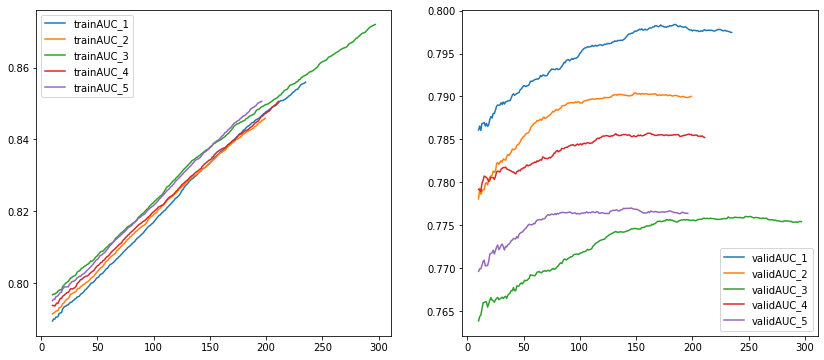

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for x in range(1,6):
    historie[['trainAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[0])
    historie[['validAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[1])
plt.show()

Możemy przeprowadzić walidację krzyżową 10 razy z różnymi ziarnami losowania i zobaczyć jak różne będą wyniki nie tylko w poszczególnych foldach, ale także średnie w kolejnych powtórzeniach. 

In [52]:
lista_wynikow = []
for k in range(10):
    wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(randomState=randint(1,10000),
        max_depth=6, lambdaX=1, subsample=0.9, colsample_bytree=0.7, gamma=0, debug=False, verbosity=0)
    lista_wynikow.append(np.mean(wyniki_testowe))
    print(np.mean(wyniki_testowe), wyniki_testowe)

0.7838111283667758 [0.7815310901138802, 0.7833491761852702, 0.7753305570705693, 0.787066331432964, 0.7917784870311954]
0.7850670004414507 [0.779250735372192, 0.7870699961333188, 0.7778884370454348, 0.7846382815872481, 0.7964875520690597]
0.7855808917414983 [0.7960170292008857, 0.780383307019971, 0.7810719017873174, 0.7758889434290128, 0.7945432772703045]
0.7852887998366039 [0.7893419972692685, 0.7721863645075115, 0.7789331878226485, 0.7937010294650881, 0.7922814201185033]
0.7850324804372807 [0.7801318369152007, 0.7944943448169124, 0.7906942771632816, 0.7801286015074622, 0.7797133417835463]
0.7839885897954344 [0.7856549099836334, 0.7867737050297607, 0.7863260131055692, 0.7784182940400783, 0.7827700268181303]
0.7845142057366459 [0.7860562097138237, 0.7935087355192606, 0.7747579652725266, 0.7777503532879259, 0.7904977648896929]
0.7853762566874232 [0.7937344528154885, 0.7916639413276184, 0.7790313103756972, 0.7885249804496102, 0.7739265984687016]
0.7848724532413923 [0.780881767732822, 0.79

In [53]:
print([round(x, 3) for x in lista_wynikow])
print(np.mean(lista_wynikow))

[0.784, 0.785, 0.786, 0.785, 0.785, 0.784, 0.785, 0.785, 0.785, 0.785]
0.7848353064501526


Wyniki są dość niestabilne przede wszystkim ze względu na dość mały zbiór treningowy, który liczy 6000 obserwacji.

# Walidacja krzyżowa: ponowny dobór parametrów

### Głębokość drzewa: max_depth

In [ ]:
Wcześniej wybraliśmy maksymalną głebokość drzewa na poziomie 6. Sprawdzimy teraz, czy wynik zmieni się po zastosowaniu walidacji krzyżowej.

[23:43:18] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:43:27] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:43:35] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[23:45:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:13] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:18] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[23:46:59] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:47:10] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:47:19] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

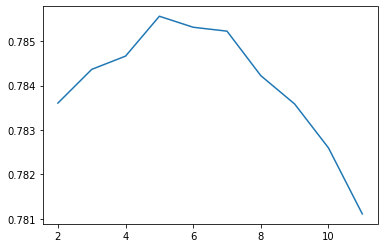

In [57]:
zakres = range(2,12)
wyniki = []
for x in zakres:
    wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(
        max_depth=x)
    print(x, np.mean(wyniki_testowe))
    wyniki.append(np.mean(wyniki_testowe))
    
plt.plot(list(zakres), wyniki)
plt.show()

Tym razem sprawdzaliśmy wyniki modelu dla każdej wartości z przedziału od 2 do 11. Najlepsze wyniki otrzymujemy dla maksymalnej głebokości drzewa na poziomie 5.

### Udział wierszy: subsample

Dla wybranej maksymalnej głębokości drzewa na poziomie 5, sprawdzamy, dla jakiej wielkości próbkowania wierszy, model osiągnie najlpesze wyniki przy zastosowaniu walidacji krzyżowej. Poprzednio zdecydowaliśmy się na wyskość parametru na poziomie 70% lub 90%. Sprawdzimy, czy walidacja krzyżowa przyniesie inne wnioski.

[23:56:48] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:52] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:56] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[23:58:07] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:58:11] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:58:16] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

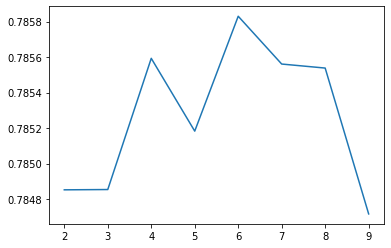

In [58]:
zakres = range(2,10)
wyniki = []
for x in zakres:
    wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(
        max_depth=5, subsample = x/10)
    print(x, np.mean(wyniki_testowe))
    wyniki.append(np.mean(wyniki_testowe))
    
plt.plot(list(zakres), wyniki)
plt.show()

Tym razem najlepsze wyniki otrzymujemy dla udziału wierszy na zdecydowanie innym poziomie. Najlepsze rezultaty przynosi próbkowanie wierszy na wysokości 60%, a nie 70% lub 90% jak podczas przygotowania modelu bez stosowania walidacji krzyżowej.

### Udział kolumn: colsample_bytree

[00:11:51] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:11:52] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:11:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[00:12:59] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:13:03] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:13:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

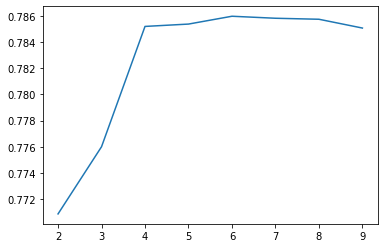

In [59]:
zakres = range(2,10)
wyniki = []
for x in zakres:
    wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(
        max_depth=5, subsample = 0.6, colsample_bytree = x/10)
    print(x, np.mean(wyniki_testowe))
    wyniki.append(np.mean(wyniki_testowe))
    
plt.plot(list(zakres), wyniki)
plt.show()

Przy zachowaniu pozostałych parametrów na wcześniej ustalonych poziomach i wykorzystaniu walidacji krzyżowej otrzymujemy informację, że najlpesze wyniki uzyskamy dla próbkowania zmiennych (z poziomu drzew, nie warstw) dla wysokości parametru colsample_bytree: 60%.

### Regularyzacja: lambda^2

Kiedy przygotowywaliśmy model bez użycia walidacji krzyżowej, zmiana parametru lambda na inny niż 1 nie przyniosła poprawy wyniku. Sprawdzimy, czy przy jej zastosowaniu osiągniemy lepsze wyniki dla większych wartości lambda.

[00:33:44] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:33:48] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:33:52] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[00:35:17] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:35:21] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:35:27] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

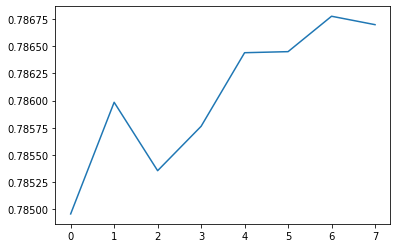

In [62]:
zakres = range(0,8)
wyniki = []
for x in zakres:
    wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(
        max_depth=5, subsample = 0.6, colsample_bytree = 0.6, lambdaX=x**2)
    print(x**2, np.mean(wyniki_testowe))
    wyniki.append(np.mean(wyniki_testowe))
    
plt.plot(list(zakres), wyniki)
plt.show()

Sprawdzamy wyniki dla lambda = 6, ponieważ dla tej wartości parametru otrzymujemy najlepszy wynik przy parametrze gamma = 0.

[01:08:37] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:08:41] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:08:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[01:09:58] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:10:02] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:10:07] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[01:11:58] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:12:05] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:12:10] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

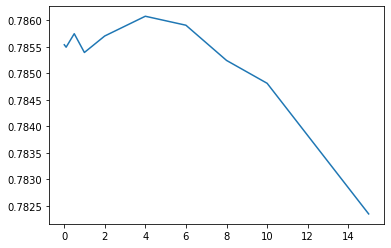

In [64]:
zakres = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
wyniki = []
for x in zakres:
    wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(
        max_depth=5, subsample = 0.6, colsample_bytree = 0.6, lambdaX=6, gamma=x)
    print(x, np.mean(wyniki_testowe))
    wyniki.append(np.mean(wyniki_testowe))
    
plt.plot(list(zakres), wyniki)
plt.show()

In [ ]:
Dla lambdy = 6, hiperparametr gamma okazuje się dawać najlepsze wyniki, kiedy jest ustwiony na poziomie 4.

# Zapis wyniku i krzywa ROC

In [66]:
wyniki_treningowe, wyniki_testowe, predykcje, indeksy, historie = walidacja_krzyzowa_xgb(
        max_depth=5, subsample = 0.6, colsample_bytree = 0.6, lambdaX=6, gamma=4)
print(np.mean(wyniki_testowe))

modelXGB = {
    "nazwa":"XGB",
    "opis":"Model XGB, ze zmiennymi kategorycznymi z label encoding.",
    "specyfikacja":'max_depth=5, subsample = 0.6, colsample_bytree = 0.6, lambdaX=6, gamma=4',
    "wyniki treningowe":wyniki_treningowe.copy(),
    "wyniki testowe":wyniki_testowe.copy(),
    "predykcje":predykcje.copy(),
    "indeksy":indeksy.copy(),
}

[01:23:02] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:23:07] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:23:10] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

In [67]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_XGB_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB, fp)

## Krzywa ROC

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score

def wykres_ROC(wyniki):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''
    
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in wyniki:
        
        # Trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Pole powierzchni pod krzywą
        oszacowanieROC = roc_auc_score(true, pred)
        oszacowanieROC = round(oszacowanieROC, 3)
        # Krzywa ROC
        ax.plot(fpr, tpr, lw=2, label=f'{label}: {oszacowanieROC}')
        
    # Krzywa 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Dodajemy marginesy do zakresu
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('Odsetek wyników fałszywie pozytywnych')
    ax.set_ylabel('Odsetek wyników prawdziwie pozytywnych')
    ax.set_title(f'Receiver operating characteristic - {oszacowanieROC}')
    ax.legend(loc="lower right")
    plt.show()

In [75]:
with open("KNN_model_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

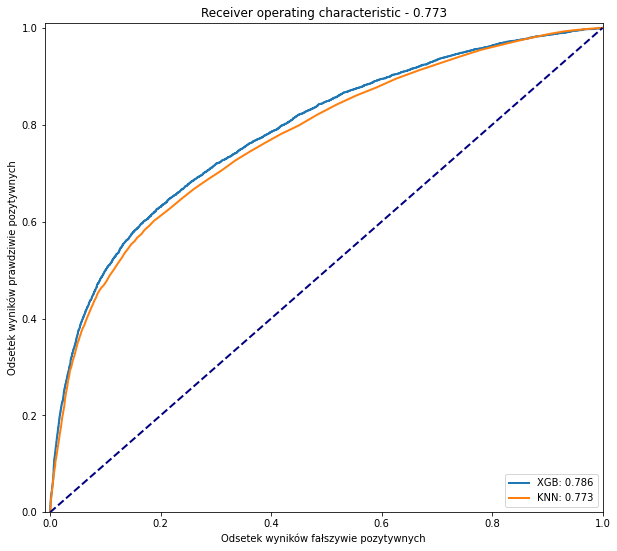

In [77]:
# from helpers import plotROCs
wynikiWYKRES = []
true = dane[objasniana].sort_index()
for wynik in [modelXGB, modelkNN]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(wynik["predykcje"], []), index=sum(wynik["indeksy"], [])).sort_index()
    wynikiWYKRES.append((true, pred, wynik["nazwa"]))
    
# Wywołujemy funkcję do rysowania
wykres_ROC(wynikiWYKRES)